# lmm.ipynb

Notebook to apply LMM to control for clade relationships in virus-infected strains when quantifying differential expression

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
import warnings

# Suppress *all* warnings globally
warnings.filterwarnings("ignore")


/tmp/ipykernel_765/423154931.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("tab20")


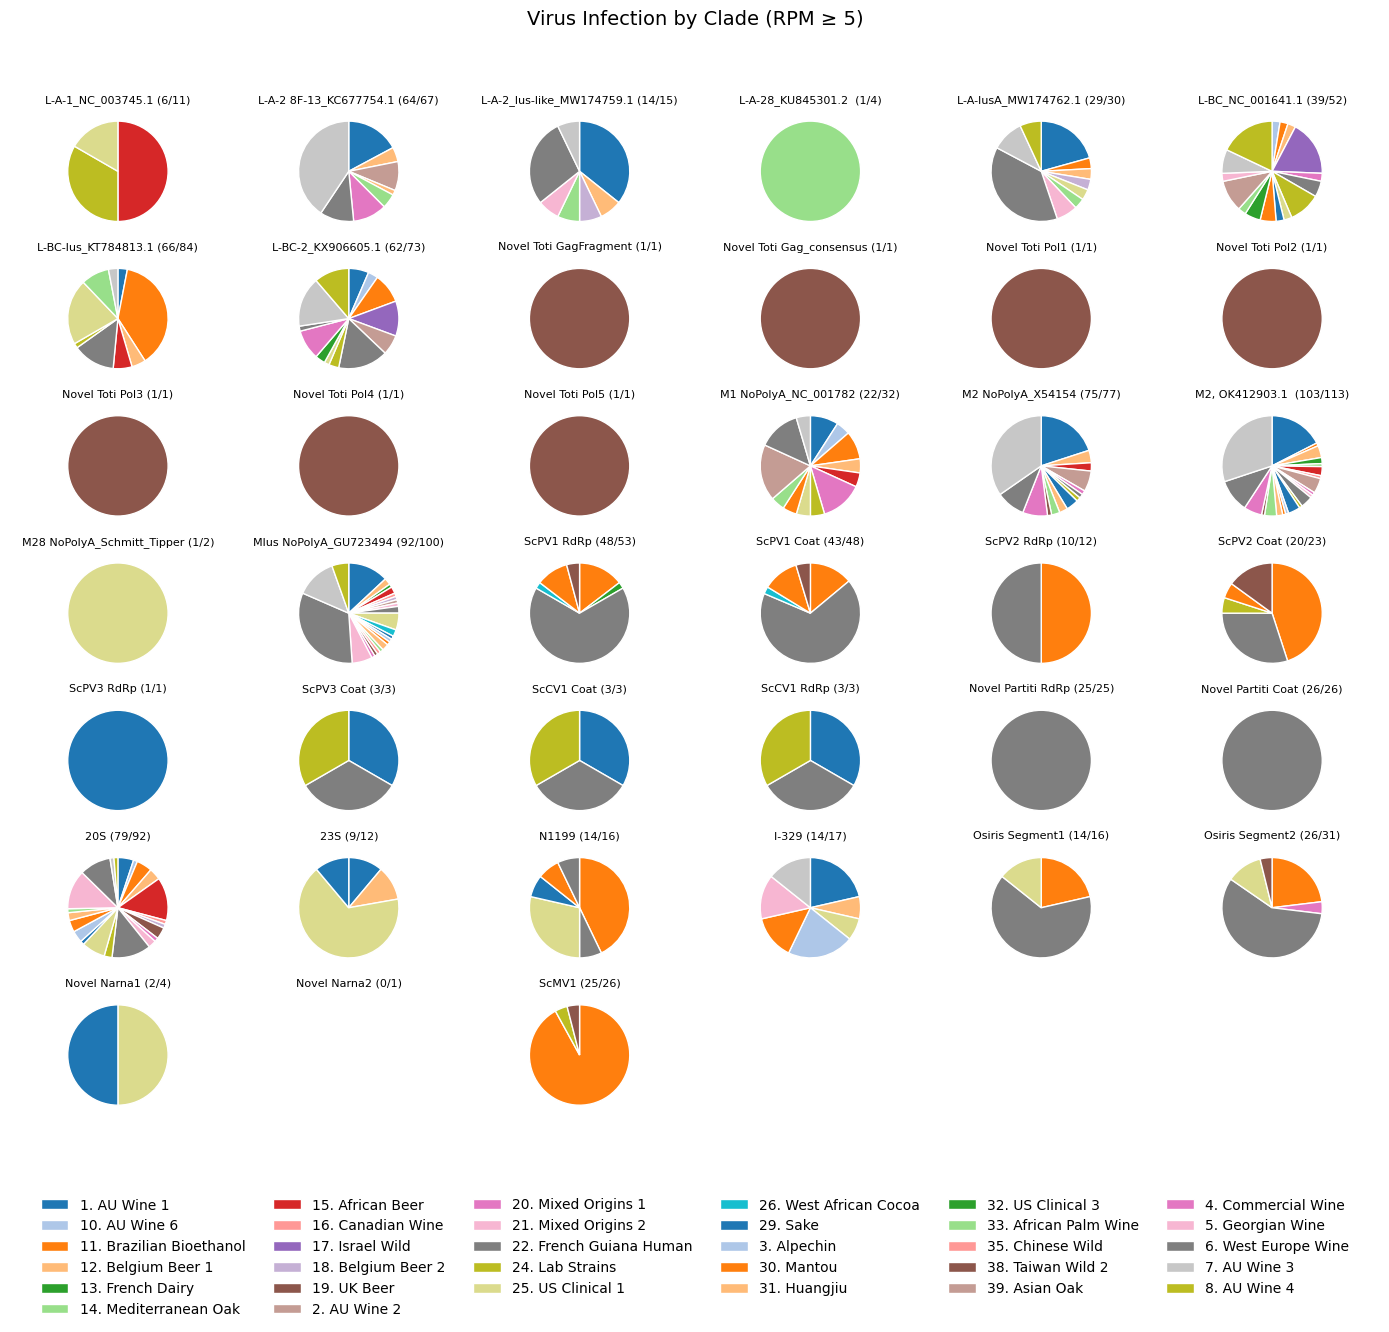

['L-A-1_NC_003745.1', 'L-A-2 8F-13_KC677754.1', 'L-A-2_lus-like_MW174759.1', 'L-A-28_KU845301.2 ', 'L-A-lusA_MW174762.1']


In [3]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
from pathlib import Path
from matplotlib.patches import Patch


def plot_virus_infection_pies(
    virome_path="data/virome250531.tsv",
    clade_path="data/strain_ecodata.csv",
    map_path="data/rnaseq_accessions.tsv",
    min_rpm=5.0,
    max_cols=6,
    figsize=(14, 12),
):
    """
    Plot per-virus pie charts showing clade composition of infected strains (RPM ≥ threshold).

    Returns list of virus names
    """

    # Load data
    mapper = pd.read_csv(map_path, sep="\t", dtype=str)
    virome = pd.read_csv(virome_path, sep="\t", dtype=str)
    clade_df = pd.read_csv(clade_path)

    # Fix numeric conversion
    virome.iloc[:, 1:] = virome.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

    # Merge all metadata
    merged = virome.merge(mapper[["accession", "std_name"]], on="accession", how="inner")
    merged = merged.merge(
        clade_df[["std_name", "Clade"]].rename(columns={"Clade": "clade"}),
        on="std_name",
        how="left",
    )

    virus_cols = [col for col in merged.columns if col not in {"accession", "std_name", "clade"}]
    clades = sorted(merged["clade"].dropna().unique())
    cmap = get_cmap("tab20")
    clade_colors = {clade: cmap(i % 20) for i, clade in enumerate(clades)}

    # Track which clades are used (for legend)
    clades_used = set()

    # Layout
    n = len(virus_cols)
    ncols = min(n, max_cols)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()

    for i, virus in enumerate(virus_cols):
        df = merged[["std_name", "clade", virus]].copy()
        df["infected"] = df[virus] >= min_rpm
        infected = df[df["infected"]]

        # Count by clade
        clade_counts = infected["clade"].value_counts().sort_index()
        labels = clade_counts.index.tolist()
        sizes = clade_counts.values
        colors = [clade_colors.get(c, "gray") for c in labels]
        clades_used.update(labels)

        ax = axs[i]
        ax.pie(
            sizes,
            colors=colors,
            startangle=90,
            counterclock=False,
            wedgeprops={"edgecolor": "white"},
        )

        # Title: Virus (N_in_clade / N_total_infected)
        n_infected = len(infected)
        n_in_clade = clade_counts.sum()
        ax.set_title(f"{virus} ({n_in_clade}/{n_infected})", fontsize=8, pad=10)
        ax.axis("equal")

    # Clean up unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Legend: horizontal below the plot
    legend_elements = [
        Patch(facecolor=clade_colors[clade], edgecolor="white", label=clade)
        for clade in sorted(clades_used)
    ]

    fig.subplots_adjust(bottom=0.2)  # reserve space
    fig.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, -0),  # push completely outside
        ncol=6,
        fontsize=10,
        frameon=False,
    )

    fig.suptitle(f"Virus Infection by Clade (RPM ≥ {min_rpm})", fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space at bottom for legend
    plt.show()

    return virus_cols


# === Call it
viruses = plot_virus_infection_pies(min_rpm=5)
print(viruses[:5])

In [4]:
# Read transcript counts matrix
counts = pd.read_csv("data/count_matrix.csv.gz", index_col=0)
print(counts.shape)
print(counts.iloc[:5, :5])

(6454, 969)
                                AAA     AAB  AAD  AAE  AAG
systematic_name                                           
X1-EC1118_1F14_0012g            0.0    25.0  0.0  0.0  0.0
X10-EC1118_1F14_0133g           0.0  1368.0  0.0  0.0  0.0
X1003-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0
X1004-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0
X1005-augustus_masked.YCM.7680  0.0     0.0  0.0  0.0  0.0


In [5]:
# Library size per strain (column)
lib_size = counts.sum(axis=0)
# Counts per million
cpm = counts.div(lib_size, axis=1) * 1e6
# Log2-transformed CPM + 1
logcpm = np.log2(cpm + 1)
logcpm.index.name = "gene"
logcpm.head()

,AAA,AAB,AAD,AAE,AAG,AAH,AAI,AAK,AAL,AAM,...,XTRA_DGX,XTRA_DGY,XTRA_DHB,XTRA_DHD,XTRA_DHE,XTRA_DHJ,XTRA_DHK,XTRA_DHO,XTRA_DHQ,XTRA_DXL
gene,,,,,,,,,,,,,,,,,,,,,
X1-EC1118_1F14_0012g,0.0,3.191946,0.0,0.0,0.0,3.994808,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10-EC1118_1F14_0133g,0.0,8.801982,0.0,0.0,0.0,4.213928,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1003-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1004-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1005-augustus_masked.YCM.7680,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Reshape to long format
long_df = logcpm.reset_index().melt(id_vars="gene", var_name="strain", value_name="logcpm")
long_df.head()

,gene,strain,logcpm
0,X1-EC1118_1F14_0012g,AAA,0.0
1,X10-EC1118_1F14_0133g,AAA,0.0
2,X1003-augustus_masked.YCM.7680,AAA,0.0
3,X1004-augustus_masked.YCM.7680,AAA,0.0
4,X1005-augustus_masked.YCM.7680,AAA,0.0


In [7]:
def load_virome_infection_status(
    path_virome, target_virus_name, min_rpm=5.0, map_path="data/rnaseq_accessions.tsv"
):
    """
    Load virome RPM matrix and return 3-letter strain infection status for a given virus.

    Parameters:
        path_virome (str/Path): Path to the virome RPM table (e.g., virome250531.tsv)
        target_virus_name (str): Column name for the virus (must match exactly)
        min_rpm (float): RPM threshold to call 'infected' (default=5.0)
        map_path (str/Path): Path to accession→std_name mapping file (e.g., rnaseq_accessions.tsv)

    Returns:
        pd.DataFrame with columns: ['std_name', 'infected']
    """
    path_virome = Path(path_virome)
    map_path = Path(map_path)

    # Load mapping (accession → std_name)
    mapper = pd.read_csv(map_path, sep="\t", dtype=str)
    if "accession" not in mapper.columns or "std_name" not in mapper.columns:
        raise ValueError("Mapping file must contain 'accession' and 'std_name' columns.")

    # Load virome matrix
    df = pd.read_csv(path_virome, sep="\t", dtype=str)
    df[target_virus_name] = pd.to_numeric(df[target_virus_name], errors="coerce")

    if target_virus_name not in df.columns:
        raise ValueError(f"Virus '{target_virus_name}' not found in virome file columns.")

    # Merge with mapper to get std_name
    merged = df.merge(mapper[["accession", "std_name"]], on="accession", how="inner")

    # Assign infection status
    out = pd.DataFrame(
        {
            "std_name": merged["std_name"],
            "infected": (merged[target_virus_name] >= min_rpm).astype(int),
        }
    )

    return out


def load_clade_mapping(path="data/strain_ecodata.csv"):
    """
    Load strain-to-clade mapping from strain_ecodata.csv.

    Returns:
        DataFrame with columns: ['std_name', 'clade']
    """
    df = pd.read_csv(path)
    if "std_name" not in df.columns or "Clade" not in df.columns:
        raise ValueError("strain_ecodata.csv must contain 'std_name' and 'Clade' columns.")

    clade_df = df[["std_name", "Clade"]].rename(columns={"Clade": "clade"}).dropna()
    clade_df["clade"] = clade_df["clade"].astype(str).str.strip()
    return clade_df


def build_metadata(virome_path, virus, min_rpm=5.0, clade_path="data/strain_ecodata.csv"):
    """
    Assemble metadata with ['std_name', 'infected', 'clade'].

    Parameters:
        virome_path (str): path to virome RPM matrix
        virus (str): virus column name
        min_rpm (float): infection threshold
        clade_path (str): path to strain_ecodata.csv

    Returns:
        pd.DataFrame with std_name, infected, clade
    """
    infection_df = load_virome_infection_status(virome_path, virus, min_rpm)
    clade_df = load_clade_mapping(clade_path)

    meta = infection_df.merge(clade_df, on="std_name", how="inner")
    meta = meta[["std_name", "infected", "clade"]]
    return meta


# Define virus of interest
virus = "N1199"

meta = build_metadata(
    virome_path="data/virome250531.tsv",
    virus=virus,
    min_rpm=5,
    clade_path="data/strain_ecodata.csv",
)
meta.head()

,std_name,infected,clade
0,AAB,0,12. Belgium Beer 1
1,AAD,0,29. Sake
2,AAE,0,5. Georgian Wine
3,AAI,0,1. AU Wine 1
4,AAK,0,5. Georgian Wine


In [41]:
import pandas as pd
from pathlib import Path

def load_virome_infection_status(
    path_virome,
    virus,
    min_rpm=5.0,
    map_path="data/rnaseq_accessions.tsv",
    background="none",          # "none" or "rest"
    ignore_cols=("accession",),
):
    """
    Load virome RPM matrix and return infection status for selected virus group.

    Parameters
    ----------
    path_virome : str or Path
        Path to the virome RPM table (TSV).
    virus : str, list, or "ANY"
        - str: single virus column
        - list: multiple virus columns (infected if any >= min_rpm)
        - "ANY": all virus columns auto-detected
    min_rpm : float
        Threshold for calling infection.
    map_path : str or Path
        Path to accession→std_name mapping file.
    background : {"none","rest"}
        "none" = background is only completely uninfected strains.
        "rest" = background is everything not infected by selected virus group.
    ignore_cols : tuple
        Columns not to treat as virus RPMs.

    Returns
    -------
    DataFrame with ['std_name','infected','background']
    """
    path_virome = Path(path_virome)
    map_path = Path(map_path)

    # load mapping
    mapper = pd.read_csv(map_path, sep="\t", dtype=str)
    if "accession" not in mapper.columns or "std_name" not in mapper.columns:
        raise ValueError("Mapping file must contain 'accession' and 'std_name'.")

    # load virome
    df = pd.read_csv(path_virome, sep="\t", dtype=str)
    if "accession" not in df.columns:
        raise ValueError("Virome file must contain 'accession'.")

    # decide virus columns
    if isinstance(virus, str) and virus.upper() == "ANY":
        virus_cols = [c for c in df.columns if c not in ignore_cols]
    elif isinstance(virus, (list, tuple)):
        virus_cols = list(virus)
    else:
        virus_cols = [virus]

    # coerce numeric
    df[virus_cols] = df[virus_cols].apply(pd.to_numeric, errors="coerce")
    all_virus_cols = [c for c in df.columns if c not in ignore_cols]
    df[all_virus_cols] = df[all_virus_cols].apply(pd.to_numeric, errors="coerce")

    # merge mapping
    merged = df.merge(mapper[["accession","std_name"]], on="accession", how="inner")

    # infection calls
    infected_mask = (merged[virus_cols] >= float(min_rpm)).any(axis=1)

    # background masks
    if background == "none":
        other_infected = (merged[all_virus_cols] >= float(min_rpm)).any(axis=1)
        background_mask = ~infected_mask & ~other_infected
    elif background == "rest":
        background_mask = ~infected_mask
    else:
        raise ValueError("background must be 'none' or 'rest'")

    out = pd.DataFrame({
        "std_name": merged["std_name"],
        "infected": infected_mask.astype(int),
        "background": background_mask.astype(int),
    })
    return out


def load_clade_mapping(path="data/strain_ecodata.csv"):
    df = pd.read_csv(path)
    if "std_name" not in df.columns or "Clade" not in df.columns:
        raise ValueError("strain_ecodata.csv must contain 'std_name' and 'Clade'.")
    return df[["std_name","Clade"]].rename(columns={"Clade":"clade"}).dropna()


def build_metadata(
    virome_path,
    virus,
    min_rpm=5.0,
    clade_path="data/strain_ecodata.csv",
    background="none",
):
    infection_df = load_virome_infection_status(
        virome_path, virus, min_rpm=min_rpm, background=background
    )
    clade_df = load_clade_mapping(clade_path)
    meta = infection_df.merge(clade_df, on="std_name", how="inner")
    return meta[["std_name","infected","background","clade"]]


# # 1. One virus vs uninfected only
meta = build_metadata("data/virome250531.tsv", virus="N1199", background="none")
# # 2. Group of viruses vs uninfected only
# meta = build_metadata("data/virome250531.tsv", virus=["N1199","N1210"], background="none")
# 3. Group of viruses vs the rest (others + uninfected)
# meta = build_metadata("data/virome250531.tsv", virus=["Osiris Segment1","Osiris Segment2"], background="none")
# 4. Any virus vs none
# meta = build_metadata("data/virome250531.tsv", virus="ANY", background="none")

In [42]:
# =============================
# Linear Mixed Model Pipeline
# =============================

import pandas as pd
import numpy as np
import warnings
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress specific model warnings
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*divide by zero.*", category=RuntimeWarning)
warnings.filterwarnings("ignore", message=".*invalid value encountered.*", category=RuntimeWarning)
warnings.filterwarnings(
    "ignore", message=".*Random effects covariance is singular.*", category=UserWarning
)

# -------------------------------
# Core: Single-gene model fitting
# -------------------------------


def _fit_lmm_per_gene(
    gene: str, dfg: pd.DataFrame, outcome: str, predictor: str, group: str
) -> dict:
    """
    Fit a mixed linear model for a single gene.

    Parameters:
        gene: gene identifier
        dfg: subset dataframe for this gene
        outcome: response variable (e.g., 'logcpm')
        predictor: binary variable of interest (e.g., 'infected')
        group: random effect grouping (e.g., 'clade')

    Returns:
        Dictionary with gene, beta, pval
    """
    # Suppress inside each subprocess
    warnings.simplefilter("ignore", ConvergenceWarning)
    warnings.filterwarnings("ignore", message=".*divide by zero.*", category=RuntimeWarning)
    warnings.filterwarnings(
        "ignore", message=".*invalid value encountered.*", category=RuntimeWarning
    )
    warnings.filterwarnings(
        "ignore", message=".*Random effects covariance is singular.*", category=UserWarning
    )

    if dfg[predictor].nunique() < 2:
        return {"gene": gene, "beta": np.nan, "pval": np.nan}

    try:
        model = mixedlm(f"{outcome} ~ {predictor}", dfg, groups=dfg[group])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            fit = model.fit(reml=False)
        return {
            "gene": gene,
            "beta": fit.params.get(predictor, np.nan),
            "pval": fit.pvalues.get(predictor, np.nan),
        }
    except Exception:
        return {"gene": gene, "beta": np.nan, "pval": np.nan}


# -------------------------------
# Public API: Parallel LMM runner
# -------------------------------


def run_lmm_joblib(
    long_df: pd.DataFrame,
    meta_df: pd.DataFrame,
    outcome: str = "logcpm",
    predictor: str = "infected",
    group: str = "clade",
    strain_col: str = "strain",
    meta_strain_col: str = "std_name",
    n_jobs: int = 8,
) -> pd.DataFrame:
    """
    Run per-gene linear mixed models in parallel using joblib.

    Parameters:
        long_df: DataFrame with ['gene', strain_col, outcome]
        meta_df: DataFrame with [meta_strain_col, predictor, group]
        outcome: name of outcome column (default 'logcpm')
        predictor: name of binary predictor column (default 'infected')
        group: name of random effect group (default 'clade')
        strain_col: name of strain ID column in long_df
        meta_strain_col: name of strain ID column in meta_df
        n_jobs: number of parallel workers

    Returns:
        DataFrame with ['gene', 'beta', 'pval', 'fdr']
    """

    # Merge strain metadata
    df = long_df.merge(
        meta_df[[meta_strain_col, predictor, group]],
        left_on=strain_col,
        right_on=meta_strain_col,
        how="inner",
    )

    # Drop missing values in relevant columns
    df = df[["gene", outcome, predictor, group]].dropna()

    # Parallelized model fitting
    grouped = list(df.groupby("gene"))
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(_fit_lmm_per_gene)(gene, dfg, outcome, predictor, group)
        for gene, dfg in tqdm(grouped, desc="Running LMMs")
    )

    res_df = pd.DataFrame(results)

    # Multiple testing correction
    if not res_df["pval"].isnull().all():
        res_df["fdr"] = multipletests(res_df["pval"], method="fdr_bh")[1]
    else:
        res_df["fdr"] = np.nan

    return res_df


# Filter clades with fewer than N members
min_clade_members = 3
valid_clades = meta["clade"].value_counts()[lambda x: x >= min_clade_members].index
meta = meta[meta["clade"].isin(valid_clades)]

results = run_lmm_joblib(long_df, meta, n_jobs=8)
results.head()

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

,gene,beta,pval,fdr
0,X1-EC1118_1F14_0012g,-0.086157,0.691956,NaN
1,X10-EC1118_1F14_0133g,-0.118932,0.694931,NaN
2,X1003-augustus_masked.YCM.7680,-0.001374,0.984444,NaN
3,X1004-augustus_masked.YCM.7680,-0.001082,0.984418,NaN
4,X1005-augustus_masked.YCM.7680,-0.001745,0.983526,NaN


In [43]:
import re
import pandas as pd


def filter_systematic_orfs(df, gene_col="gene"):
    """
    Keep only yeast systematic ORFs (e.g. YBR123C, YGL255W-A).

    Parameters
    ----------
    df : DataFrame
        Input DataFrame with a gene column.
    gene_col : str, default "gene"
        Column name containing gene identifiers.

    Returns
    -------
    DataFrame
        Filtered DataFrame with only systematic ORFs.
    """
    orf_pattern = re.compile(r"^Y[A-P][LRM][0-9]{3}[WC](?:-[A-Z])?$")
    return df[df[gene_col].apply(lambda g: bool(orf_pattern.match(g)))].copy()


results_orfs = filter_systematic_orfs(results)
print(f"[i] Filtered to {len(results_orfs)} systematic ORFs from {len(results)} total genes.")
results_orfs.head()

[i] Filtered to 6088 systematic ORFs from 6454 total genes.


,gene,beta,pval,fdr
366,YAL001C,-0.073626,0.435785,NaN
367,YAL002W,-0.058090,0.539325,NaN
368,YAL003W,0.121691,0.275367,NaN
369,YAL005C,0.348285,0.163616,NaN
370,YAL007C,0.107732,0.329816,NaN


In [44]:
import json

import json
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests


def enrich_lmm_results(results_df, sys2std_path, sys2desc_path):
    """
    Enrich LMM results with gene name and description.

    Parameters:
        results_df: pd.DataFrame with 'gene' column (systematic name)
        sys2std_path: Path to JSON mapping of sys → std gene names
        sys2desc_path: Path to JSON mapping of sys → gene description

    Returns:
        DataFrame with columns: gene, std_gene, description, label, beta, pval, fdr
    """
    # Load mappings
    with open(sys2std_path, encoding="utf-8") as f:
        sys_to_std = json.load(f)
    with open(sys2desc_path, encoding="utf-8") as f:
        sys_to_desc = json.load(f)

    # Filter valid ORFs
    df = results_df[~results_df["gene"].str.contains("_")].copy()

    # Add name/desc
    df["std_gene"] = df["gene"].map(sys_to_std).fillna(df["gene"])
    df["description"] = df["gene"].map(sys_to_desc).fillna("")

    # Label format
    df["label"] = np.where(
        df["std_gene"] != df["gene"], df["std_gene"] + " (" + df["gene"] + ")", df["gene"]
    )

    # Recompute FDR if needed
    if "fdr" not in df.columns or df["fdr"].isnull().all():
        valid_p = df["pval"].dropna()
        fdr = pd.Series(np.nan, index=df.index)
        if not valid_p.empty:
            fdr_vals = multipletests(valid_p.values, method="fdr_bh")[1]
            fdr.loc[valid_p.index] = fdr_vals
        df["fdr"] = fdr

    return df[["gene", "std_gene", "description", "label", "beta", "pval", "fdr"]]


# Paths to your JSON files
SYS2STD = Path("data/sys_gene_to_std_gene_map.json")
SYS2DESC = Path("data/sys_gene_to_description_map.json")

# Your LMM result DataFrame (from `run_lmm_from_strainmeta`)
enriched = enrich_lmm_results(results_orfs, SYS2STD, SYS2DESC)
enriched = enriched.sort_values("beta", ascending=False)
enriched.head()

,gene,std_gene,description,label,beta,pval,fdr
4231,YLR156C-A,YLR156C-A,Putative protein of unknown function; identifi...,YLR156C-A,1.942043,1.696972e-04,0.151653
4232,YLR159C-A,YLR159C-A,Putative protein of unknown function; identifi...,YLR159C-A,1.937075,1.743714e-04,0.151653
2339,YGL088W,YGL088W,Putative protein of unknown function; conserve...,YGL088W,1.913289,4.288241e-08,0.000261
6159,YPL187W,MF(ALPHA)1,"Mating pheromone alpha-factor, made by alpha c...",MF(ALPHA)1 (YPL187W),1.304039,4.051659e-02,0.446458
5473,YOL052C-A,DDR2,Multi-stress response protein; expression is a...,DDR2 (YOL052C-A),1.060259,2.032289e-02,0.406832


In [45]:
import pandas as pd


def filter_enriched(enriched, lfc_filter="up", fdr_thresh=0.15, lfc_cutoff=0.0):
    """
    Filter enriched results by FDR and log2 fold-change.

    Parameters
    ----------
    enriched : DataFrame
        Must contain columns ['beta', 'fdr'].
    lfc_filter : {"up", "down", None}, default "up"
        Direction of log2FC filtering.
    fdr_thresh : float, default 0.15
        Maximum allowed FDR.
    lfc_cutoff : float, default 0.0
        Absolute log2 fold-change threshold.

    Returns
    -------
    filtered : DataFrame
        Filtered enrichment results.
    """
    filtered = enriched.copy()

    if lfc_filter == "up":
        filtered = filtered[
            (filtered["fdr"].notna())
            & (filtered["fdr"] < fdr_thresh)
            & (filtered["beta"] >= lfc_cutoff)
        ]
    elif lfc_filter == "down":
        filtered = filtered[
            (filtered["fdr"].notna())
            & (filtered["fdr"] < fdr_thresh)
            & (filtered["beta"] <= -lfc_cutoff)
        ].sort_values("beta")
    elif lfc_filter is None:
        filtered = filtered[(filtered["fdr"].notna()) & (filtered["fdr"] < fdr_thresh)]
    else:
        raise ValueError("lfc_filter must be 'up', 'down', or None")

    # always sort by FDR before returning
    return filtered.sort_values("fdr", ascending=True).reset_index(drop=True)


# Apply filtering
LFC_FILTER = 'up'
filtered = filter_enriched(enriched, lfc_filter=LFC_FILTER, fdr_thresh=0.25, lfc_cutoff=0.0)

# # Export (outside the function)
# filtered.to_csv(
#     f'~/Desktop/{virus.lower().replace(" ", "_")}_sig_{LFC_FILTER}reg_genes.csv',
#     index=False
# )

# Preview (outside the function)
print(f"Columns in `filtered`: {filtered.columns}")
filtered[["label", "description", "beta", "fdr"]].head(20).style.set_properties(
    subset=["description"],
    **{"white-space": "pre-wrap", "word-wrap": "break-word", "max-width": "800px"},
)

Columns in `filtered`: Index(['gene', 'std_gene', 'description', 'label', 'beta', 'pval', 'fdr'], dtype='object')


,label,description,beta,fdr
0,YGL088W,"Putative protein of unknown function; conserved across S. cerevisiae strains; partially overlaps snR10, a snoRNA required for preRNA processing",1.913289,0.000261
1,YMR013W-A,"Dubious open reading frame; unlikely to encode a functional protein, based on available experimental and comparative sequence data; completely overlaps the characterized snoRNA gene snR73",0.706723,0.062360
2,PIG1 (YLR273C),"Putative targeting subunit for type-1 protein phosphatase Glc7p; tethers Glc7p to Gsy2p glycogen synthase; PIG1 has a paralog, GAC1, that arose from the whole genome duplication",0.689044,0.117168
3,YLR156C-A,"Putative protein of unknown function; identified by fungal homology comparisons and RT-PCR; partially overlaps RND5-3; YLR156C-A has a paralog, YLR159C-A, that arose from a segmental duplication",1.942043,0.151653
4,YLR159C-A,"Putative protein of unknown function; identified by fungal homology comparisons and RT-PCR; partially overlaps RND5-5; YLR159C-A has a paralog, YLR156C-A, that arose from a segmental duplication",1.937075,0.151653
5,YJL047C-A,Putative protein of unknown function,0.640878,0.162396
6,REC102 (YLR329W),Protein involved in early stages of meiotic recombination; required for chromosome synapsis; forms a complex with Rec104p and Spo11p necessary during the initiation of recombination,0.474739,0.162396


In [15]:
import json
import numpy as np
import pandas as pd
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests


def run_go_bp_enrichment(
    results_orfs,
    ranks,
    go_json_path,
    lfc_cutoff=1.0,
    fdr_thresh=0.15,
    lfc_direction=None,
    lfc_column="log2FC",
):
    """
    Run GO BP enrichment using hypergeometric test.

    Parameters
    ----------
    results_orfs : DataFrame
        Must have a 'gene' column with background set.
    ranks : Series or DataFrame index
        Ranked genes of interest (index = gene IDs).
    go_json_path : str
        Path to GO BP JSON annotations.
    lfc_cutoff : float, optional
        Log2 fold-change threshold (default 1.0). Used to filter hits if lfc_direction is provided.
    fdr_thresh : float, optional
        FDR threshold (default 0.15).
    lfc_direction : {"up","down","both",None}, optional
        If provided, restricts 'top' genes to those meeting the log2FC criterion.
    lfc_column : str, optional
        Column name in results_orfs that contains log2FC values (default "log2FC").

    Returns
    -------
    hits_df : DataFrame
        Enriched GO terms with overlap, term size, pval, fdr.
    """
    # ------------------------
    # Load GO annotations
    # ------------------------
    with open(go_json_path, encoding="utf-8") as f:
        go_bp = json.load(f)

    # ------------------------
    # Prepare gene sets
    # ------------------------
    # Background universe (unchanged)
    all_genes = set(results_orfs["gene"])

    # Start from all ranked genes (index = gene IDs)
    ranked_genes = pd.Index(ranks.index)

    # Optionally restrict ranked genes by log2FC direction/threshold
    if (lfc_direction is not None) and (lfc_column in results_orfs.columns):
        df_fc = results_orfs.set_index("gene")
        # Align to available genes
        df_fc = df_fc.reindex(ranked_genes).dropna(subset=[lfc_column])
        if lfc_direction == "up":
            mask = df_fc[lfc_column] >= float(lfc_cutoff)
        elif lfc_direction == "down":
            mask = df_fc[lfc_column] <= -float(lfc_cutoff)
        elif lfc_direction == "both":
            mask = df_fc[lfc_column].abs() >= float(lfc_cutoff)
        else:
            mask = pd.Series(True, index=df_fc.index)  # fall back: no filter

        filtered_ranked = df_fc.index[mask]
        top_genes = set(filtered_ranked)
    else:
        # No LFC filtering applied
        top_genes = set(ranked_genes)

    # Ensure top genes are within the background
    top_genes &= all_genes

    # ------------------------
    # Hypergeometric test
    # ------------------------
    hits = []
    M = len(all_genes)  # total background size
    n = len(top_genes)  # number of "top" genes

    for go_id, entry in go_bp.items():
        genes = set(entry["genes"])
        k = len(genes & top_genes)  # overlap with top genes
        N = len(genes & all_genes)  # overlap with background

        if k > 0 and N > 0:  # skip if no overlap
            pval = hypergeom.sf(k - 1, M, N, n)  # survival fn for enrichment
            hits.append(
                {
                    "go_id": go_id,
                    "name": entry["name"],
                    "overlap": k,
                    "term_size": N,
                    "pval": pval,
                }
            )

    # ------------------------
    # Assemble results DataFrame
    # ------------------------
    hits_df = pd.DataFrame(hits)

    # Filter GO terms by size range (avoid very small/large)
    if not hits_df.empty:
        hits_df = hits_df[(hits_df["term_size"] >= 4) & (hits_df["term_size"] <= 75)].copy()

    # Adjust p-values using FDR (Benjamini-Hochberg)
    if not hits_df.empty and hits_df["pval"].notna().any():
        hits_df["fdr"] = multipletests(hits_df["pval"], method="fdr_bh")[1]
    else:
        hits_df["fdr"] = np.nan

    # Apply enrichment cutoffs
    if not hits_df.empty:
        hits_df = hits_df[(hits_df["fdr"] < fdr_thresh) & (hits_df["overlap"] > 1)]
        hits_df = hits_df.sort_values("fdr").reset_index(drop=True)

    return hits_df


# Build ranks (you used FDR ascending; that's fine — enrichment uses only the index)
ranks = filtered.set_index("gene")["fdr"].abs().sort_values(ascending=True)

# Run enrichment; pass your existing LFC filter flag here
go_bp_df = run_go_bp_enrichment(
    results_orfs=results_orfs,
    ranks=ranks,
    go_json_path="data/annotations/go_bp.json",
    lfc_cutoff=0.5,
    fdr_thresh=0.05,
    lfc_direction=LFC_FILTER,  # e.g., "up", "down", "both", or None
)

# Printing / reporting kept OUTSIDE
true_fc = 2**1.0
print("=" * 80)
print(f"[{virus}] GO BP Enrichment Analysis")
print(
    f"Filtering: LFC direction = {LFC_FILTER or 'none'}, "
    f"log2FC threshold = {1.0:.2f} (fold change ±{true_fc:.2f}×), "
    f"FDR < {0.15}"
)
print("=" * 80)

go_bp_df.head(25)

[N1199] GO BP Enrichment Analysis
Filtering: LFC direction = up, log2FC threshold = 1.00 (fold change ±2.00×), FDR < 0.15


,go_id,name,overlap,term_size,pval,fdr


## Pipeline to measure DE genes and terms per mycovirus

Use the functions defined above to make a chained call. Organize results in their own directories in data/

In [17]:
# Fixed paths
SYS2STD = Path("data/sys_gene_to_std_gene_map.json")
SYS2DESC = Path("data/sys_gene_to_description_map.json")

In [18]:
# Define virus of interest
virus = viruses[0]
# virus = '20S'

print(f"Exploring virus-driven DEGs for mycovirus {virus}")

# Build metadata
meta = build_metadata(
    virome_path="data/virome250531.tsv",
    virus=virus,
    min_rpm=5,
    clade_path="data/strain_ecodata.csv",
)

Exploring virus-driven DEGs for mycovirus L-A-1_NC_003745.1


In [20]:
# Filter clades with fewer than N members
min_clade_members = 3
valid_clades = meta["clade"].value_counts()[lambda x: x >= min_clade_members].index
meta = meta[meta["clade"].isin(valid_clades)]

# Run LMM
results = run_lmm_joblib(long_df, meta, n_jobs=12)
# Only filter for ORFs with registered systematic gene names
results_orfs = filter_systematic_orfs(results)
print(f"[i] Filtered to {len(results_orfs)} systematic ORFs from {len(results)} total genes.")
results_orfs.head()

Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] Filtered to 6088 systematic ORFs from 6454 total genes.


,gene,beta,pval,fdr
366,YAL001C,-0.045351,0.751238,NaN
367,YAL002W,-0.063498,0.658082,NaN
368,YAL003W,0.232062,0.172102,NaN
369,YAL005C,-0.466319,0.223598,NaN
370,YAL007C,-0.141409,0.399423,NaN


In [21]:
# Find enriched genes from LMM results
enriched = enrich_lmm_results(results_orfs, SYS2STD, SYS2DESC)
enriched = enriched.sort_values("beta", ascending=False)

# Apply filtering
filtered = filter_enriched(enriched, lfc_filter="up", fdr_thresh=0.25, lfc_cutoff=0.0)
# Export (outside the function)
filtered.to_csv(
    f'~/Desktop/{virus.lower().replace(" ", "_")}_sig_{LFC_FILTER}reg_genes.csv', index=False
)
# Preview (outside the function)
filtered[["label", "description", "beta", "fdr"]].head(20).style.set_properties(
    subset=["description"],
    **{"white-space": "pre-wrap", "word-wrap": "break-word", "max-width": "800px"},
)

,label,description,beta,fdr
0,YAR030C,"Dubious open reading frame; unlikely to encode a functional protein, based on available experimental and comparative sequence data; partially overlaps the uncharacterized ORF YAR029W and the verified gene PRM9",2.779441,0.000000
1,DFP2 (YAR029W),Member of DUP240 gene family but contains no transmembrane domains; green fluorescent protein (GFP)-fusion protein localizes to the cytoplasm in a punctate pattern,2.685966,0.000000
2,YCR102W-A,"Dubious open reading frame; unlikely to encode a functional protein, based on available experimental and comparative sequence data",2.413090,0.000000
3,IMD2 (YHR216W),"Inosine monophosphate dehydrogenase; catalyzes the rate-limiting step in GTP biosynthesis, expression is induced by mycophenolic acid resulting in resistance to the drug, expression is repressed by nutrient limitation; IMD2 has a paralog, YAR073W/YAR075W, that arose from a segmental duplication",3.760748,0.000000
4,MST28 (YAR033W),"Putative integral membrane protein, involved in vesicle formation; forms complex with Mst27p; member of DUP240 gene family; binds COPI and COPII vesicles; MST28 has a paralog, MST27, that arose from a segmental duplication",1.643802,0.000020
5,MAL33 (YBR297W),MAL-activator protein; part of complex locus MAL3; nonfunctional in genomic reference strain S288C,2.480103,0.000034
6,PHO12 (YHR215W),"One of three repressible acid phosphatases; glycoprotein that is transported to the cell surface by the secretory pathway; pregulated by phosphate starvation; PHO12 has a paralog, PHO11, that arose from a segmental duplication",2.173964,0.000055
7,SNG1 (YGR197C),"Protein involved in resistance to nitrosoguanidine and 6-azauracil; expression is regulated by transcription factors involved in multidrug resistance; SNG1 has a paralog, YJR015W, that arose from the whole genome duplication",1.321991,0.000060
8,GTT2 (YLL060C),"Glutathione S-transferase capable of homodimerization; functional overlap with Gtt2p, Grx1p, and Grx2p; protein abundance increases in response to DNA replication stress",1.241914,0.000127
9,YLR285C-A,Putative protein of unknown function; identified by fungal homology and RT-PCR,0.989968,0.000135


In [22]:
# Build ranks (you used FDR ascending; that's fine — enrichment uses only the index)
ranks = filtered.set_index("gene")["fdr"].abs().sort_values(ascending=True)

# Run enrichment; pass your existing LFC filter flag here
go_bp_df = run_go_bp_enrichment(
    results_orfs=results_orfs,
    ranks=ranks,
    go_json_path="data/annotations/go_bp.json",
    lfc_cutoff=0,
    fdr_thresh=0.25,
    lfc_direction=LFC_FILTER,  # e.g., "up", "down", "both", or None
)

# Printing / reporting kept OUTSIDE
true_fc = 2**1.0
print("=" * 80)
print(f"[{virus}] GO BP Enrichment Analysis")
print(
    f"Filtering: LFC direction = {LFC_FILTER or 'none'}, "
    f"log2FC threshold = {1.0:.2f} (fold change ±{true_fc:.2f}×), "
    f"FDR < {0.15}"
)
print("=" * 80)

go_bp_df.head(25)

[L-A-1_NC_003745.1] GO BP Enrichment Analysis
Filtering: LFC direction = up, log2FC threshold = 1.00 (fold change ±2.00×), FDR < 0.15


,go_id,name,overlap,term_size,pval,fdr
0,GO:0042819,vitamin B6 biosynthetic process,4,6,0.000013,0.004163
1,GO:0042823,pyridoxal phosphate biosynthetic process,4,9,0.000102,0.016236
2,GO:0043328,protein transport to vacuole involved in ubiqu...,5,27,0.001296,0.102679
3,GO:0000747,conjugation with cellular fusion,5,26,0.001083,0.102679
4,GO:0008643,carbohydrate transport,4,22,0.004325,0.147338
5,GO:0000023,maltose metabolic process,3,12,0.005345,0.147338
6,GO:0006520,amino acid metabolic process,4,22,0.004325,0.147338
7,GO:0000017,alpha-glucoside transport,2,4,0.005577,0.147338
8,GO:0015797,mannitol transmembrane transport,2,4,0.005577,0.147338
9,GO:0009228,thiamine biosynthetic process,3,12,0.005345,0.147338


In [25]:
# One pipeline to stitch it all together
import os


for virus in viruses:
    print(f"\n=== Processing {virus} ===")

    # -------------------------------------------------------------------------
    # Metadata and model
    # -------------------------------------------------------------------------
    meta = build_metadata(
        virome_path="data/virome250531.tsv",
        virus=virus,
        min_rpm=5,
        clade_path="data/strain_ecodata.csv",
    )
    # filter clades
    min_clade_members = 3
    valid_clades = meta["clade"].value_counts()[lambda x: x >= min_clade_members].index
    meta = meta[meta["clade"].isin(valid_clades)]

    results = run_lmm_joblib(long_df, meta, n_jobs=16)
    results_orfs = filter_systematic_orfs(results)
    print(f"[i] {virus}: {len(results_orfs)} systematic ORFs of {len(results)} total genes")

    enriched = enrich_lmm_results(results_orfs, SYS2STD, SYS2DESC)
    enriched = enriched.sort_values("beta", ascending=False)

    # -------------------------------------------------------------------------
    # Make output dirs
    # -------------------------------------------------------------------------
    base_dir = f"data/lmm/{virus.lower().replace(' ', '_')}"
    gene_dir = os.path.join(base_dir, "genes")
    gobp_dir = os.path.join(base_dir, "gobp")
    os.makedirs(gene_dir, exist_ok=True)
    os.makedirs(gobp_dir, exist_ok=True)

    # -------------------------------------------------------------------------
    # Export DEG tables (no FDR cutoff – keep everything)
    # -------------------------------------------------------------------------
    for direction in ["up", "down"]:
        filtered = filter_enriched(
            enriched, lfc_filter=direction, fdr_thresh=1.0, lfc_cutoff=0.0
        ).sort_values("fdr")

        gene_path = os.path.join(
            gene_dir, f"{direction}_{virus.lower().replace(' ', '_')}_genes.csv"
        )
        filtered.to_csv(gene_path, index=False)
        print(f"[i] {virus} {direction}: exported DEG table -> {gene_path}")

        # ---------------------------------------------------------------------
        # GO BP enrichment (use FDR<0.15 genes for input, lfc_cutoff=0)
        # ---------------------------------------------------------------------
        sig_filtered = filter_enriched(
            enriched, lfc_filter=direction, fdr_thresh=0.15, lfc_cutoff=0.0
        )
        ranks = sig_filtered.set_index("gene")["fdr"].abs().sort_values()

        go_bp_df = run_go_bp_enrichment(
            results_orfs=results_orfs,
            ranks=ranks,
            go_json_path="data/annotations/go_bp.json",
            lfc_cutoff=0.0,
            fdr_thresh=0.5,  # modify output filter
            lfc_direction=direction,
        )

        gobp_path = os.path.join(
            gobp_dir, f"{direction}_{virus.lower().replace(' ', '_')}_gobp.csv"
        )
        go_bp_df.to_csv(gobp_path, index=False)
        print(f"[i] {virus} {direction}: exported GO BP enrichment -> {gobp_path}")


=== Processing L-A-1_NC_003745.1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] L-A-1_NC_003745.1: 6088 systematic ORFs of 6454 total genes
[i] L-A-1_NC_003745.1 up: exported DEG table -> data/lmm/l-a-1_nc_003745.1/genes/up_l-a-1_nc_003745.1_genes.csv
[i] L-A-1_NC_003745.1 up: exported GO BP enrichment -> data/lmm/l-a-1_nc_003745.1/gobp/up_l-a-1_nc_003745.1_gobp.csv
[i] L-A-1_NC_003745.1 down: exported DEG table -> data/lmm/l-a-1_nc_003745.1/genes/down_l-a-1_nc_003745.1_genes.csv
[i] L-A-1_NC_003745.1 down: exported GO BP enrichment -> data/lmm/l-a-1_nc_003745.1/gobp/down_l-a-1_nc_003745.1_gobp.csv

=== Processing L-A-2 8F-13_KC677754.1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] L-A-2 8F-13_KC677754.1: 6088 systematic ORFs of 6454 total genes
[i] L-A-2 8F-13_KC677754.1 up: exported DEG table -> data/lmm/l-a-2_8f-13_kc677754.1/genes/up_l-a-2_8f-13_kc677754.1_genes.csv
[i] L-A-2 8F-13_KC677754.1 up: exported GO BP enrichment -> data/lmm/l-a-2_8f-13_kc677754.1/gobp/up_l-a-2_8f-13_kc677754.1_gobp.csv
[i] L-A-2 8F-13_KC677754.1 down: exported DEG table -> data/lmm/l-a-2_8f-13_kc677754.1/genes/down_l-a-2_8f-13_kc677754.1_genes.csv
[i] L-A-2 8F-13_KC677754.1 down: exported GO BP enrichment -> data/lmm/l-a-2_8f-13_kc677754.1/gobp/down_l-a-2_8f-13_kc677754.1_gobp.csv

=== Processing L-A-2_lus-like_MW174759.1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] L-A-2_lus-like_MW174759.1: 6088 systematic ORFs of 6454 total genes
[i] L-A-2_lus-like_MW174759.1 up: exported DEG table -> data/lmm/l-a-2_lus-like_mw174759.1/genes/up_l-a-2_lus-like_mw174759.1_genes.csv
[i] L-A-2_lus-like_MW174759.1 up: exported GO BP enrichment -> data/lmm/l-a-2_lus-like_mw174759.1/gobp/up_l-a-2_lus-like_mw174759.1_gobp.csv
[i] L-A-2_lus-like_MW174759.1 down: exported DEG table -> data/lmm/l-a-2_lus-like_mw174759.1/genes/down_l-a-2_lus-like_mw174759.1_genes.csv
[i] L-A-2_lus-like_MW174759.1 down: exported GO BP enrichment -> data/lmm/l-a-2_lus-like_mw174759.1/gobp/down_l-a-2_lus-like_mw174759.1_gobp.csv

=== Processing L-A-28_KU845301.2  ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] L-A-28_KU845301.2 : 6088 systematic ORFs of 6454 total genes
[i] L-A-28_KU845301.2  up: exported DEG table -> data/lmm/l-a-28_ku845301.2_/genes/up_l-a-28_ku845301.2__genes.csv
[i] L-A-28_KU845301.2  up: exported GO BP enrichment -> data/lmm/l-a-28_ku845301.2_/gobp/up_l-a-28_ku845301.2__gobp.csv
[i] L-A-28_KU845301.2  down: exported DEG table -> data/lmm/l-a-28_ku845301.2_/genes/down_l-a-28_ku845301.2__genes.csv
[i] L-A-28_KU845301.2  down: exported GO BP enrichment -> data/lmm/l-a-28_ku845301.2_/gobp/down_l-a-28_ku845301.2__gobp.csv

=== Processing L-A-lusA_MW174762.1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] L-A-lusA_MW174762.1: 6088 systematic ORFs of 6454 total genes
[i] L-A-lusA_MW174762.1 up: exported DEG table -> data/lmm/l-a-lusa_mw174762.1/genes/up_l-a-lusa_mw174762.1_genes.csv
[i] L-A-lusA_MW174762.1 up: exported GO BP enrichment -> data/lmm/l-a-lusa_mw174762.1/gobp/up_l-a-lusa_mw174762.1_gobp.csv
[i] L-A-lusA_MW174762.1 down: exported DEG table -> data/lmm/l-a-lusa_mw174762.1/genes/down_l-a-lusa_mw174762.1_genes.csv
[i] L-A-lusA_MW174762.1 down: exported GO BP enrichment -> data/lmm/l-a-lusa_mw174762.1/gobp/down_l-a-lusa_mw174762.1_gobp.csv

=== Processing L-BC_NC_001641.1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] L-BC_NC_001641.1: 6088 systematic ORFs of 6454 total genes
[i] L-BC_NC_001641.1 up: exported DEG table -> data/lmm/l-bc_nc_001641.1/genes/up_l-bc_nc_001641.1_genes.csv
[i] L-BC_NC_001641.1 up: exported GO BP enrichment -> data/lmm/l-bc_nc_001641.1/gobp/up_l-bc_nc_001641.1_gobp.csv
[i] L-BC_NC_001641.1 down: exported DEG table -> data/lmm/l-bc_nc_001641.1/genes/down_l-bc_nc_001641.1_genes.csv
[i] L-BC_NC_001641.1 down: exported GO BP enrichment -> data/lmm/l-bc_nc_001641.1/gobp/down_l-bc_nc_001641.1_gobp.csv

=== Processing L-BC-lus_KT784813.1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] L-BC-lus_KT784813.1: 6088 systematic ORFs of 6454 total genes
[i] L-BC-lus_KT784813.1 up: exported DEG table -> data/lmm/l-bc-lus_kt784813.1/genes/up_l-bc-lus_kt784813.1_genes.csv
[i] L-BC-lus_KT784813.1 up: exported GO BP enrichment -> data/lmm/l-bc-lus_kt784813.1/gobp/up_l-bc-lus_kt784813.1_gobp.csv
[i] L-BC-lus_KT784813.1 down: exported DEG table -> data/lmm/l-bc-lus_kt784813.1/genes/down_l-bc-lus_kt784813.1_genes.csv
[i] L-BC-lus_KT784813.1 down: exported GO BP enrichment -> data/lmm/l-bc-lus_kt784813.1/gobp/down_l-bc-lus_kt784813.1_gobp.csv

=== Processing L-BC-2_KX906605.1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] L-BC-2_KX906605.1: 6088 systematic ORFs of 6454 total genes
[i] L-BC-2_KX906605.1 up: exported DEG table -> data/lmm/l-bc-2_kx906605.1/genes/up_l-bc-2_kx906605.1_genes.csv
[i] L-BC-2_KX906605.1 up: exported GO BP enrichment -> data/lmm/l-bc-2_kx906605.1/gobp/up_l-bc-2_kx906605.1_gobp.csv
[i] L-BC-2_KX906605.1 down: exported DEG table -> data/lmm/l-bc-2_kx906605.1/genes/down_l-bc-2_kx906605.1_genes.csv
[i] L-BC-2_KX906605.1 down: exported GO BP enrichment -> data/lmm/l-bc-2_kx906605.1/gobp/down_l-bc-2_kx906605.1_gobp.csv

=== Processing Novel Toti GagFragment ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] Novel Toti GagFragment: 6088 systematic ORFs of 6454 total genes
[i] Novel Toti GagFragment up: exported DEG table -> data/lmm/novel_toti_gagfragment/genes/up_novel_toti_gagfragment_genes.csv
[i] Novel Toti GagFragment up: exported GO BP enrichment -> data/lmm/novel_toti_gagfragment/gobp/up_novel_toti_gagfragment_gobp.csv
[i] Novel Toti GagFragment down: exported DEG table -> data/lmm/novel_toti_gagfragment/genes/down_novel_toti_gagfragment_genes.csv
[i] Novel Toti GagFragment down: exported GO BP enrichment -> data/lmm/novel_toti_gagfragment/gobp/down_novel_toti_gagfragment_gobp.csv

=== Processing Novel Toti Gag_consensus ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Novel Toti Gag_consensus: 6088 systematic ORFs of 6454 total genes
[i] Novel Toti Gag_consensus up: exported DEG table -> data/lmm/novel_toti_gag_consensus/genes/up_novel_toti_gag_consensus_genes.csv
[i] Novel Toti Gag_consensus up: exported GO BP enrichment -> data/lmm/novel_toti_gag_consensus/gobp/up_novel_toti_gag_consensus_gobp.csv
[i] Novel Toti Gag_consensus down: exported DEG table -> data/lmm/novel_toti_gag_consensus/genes/down_novel_toti_gag_consensus_genes.csv
[i] Novel Toti Gag_consensus down: exported GO BP enrichment -> data/lmm/novel_toti_gag_consensus/gobp/down_novel_toti_gag_consensus_gobp.csv

=== Processing Novel Toti Pol1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] Novel Toti Pol1: 6088 systematic ORFs of 6454 total genes
[i] Novel Toti Pol1 up: exported DEG table -> data/lmm/novel_toti_pol1/genes/up_novel_toti_pol1_genes.csv
[i] Novel Toti Pol1 up: exported GO BP enrichment -> data/lmm/novel_toti_pol1/gobp/up_novel_toti_pol1_gobp.csv
[i] Novel Toti Pol1 down: exported DEG table -> data/lmm/novel_toti_pol1/genes/down_novel_toti_pol1_genes.csv
[i] Novel Toti Pol1 down: exported GO BP enrichment -> data/lmm/novel_toti_pol1/gobp/down_novel_toti_pol1_gobp.csv

=== Processing Novel Toti Pol2 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Novel Toti Pol2: 6088 systematic ORFs of 6454 total genes
[i] Novel Toti Pol2 up: exported DEG table -> data/lmm/novel_toti_pol2/genes/up_novel_toti_pol2_genes.csv
[i] Novel Toti Pol2 up: exported GO BP enrichment -> data/lmm/novel_toti_pol2/gobp/up_novel_toti_pol2_gobp.csv
[i] Novel Toti Pol2 down: exported DEG table -> data/lmm/novel_toti_pol2/genes/down_novel_toti_pol2_genes.csv
[i] Novel Toti Pol2 down: exported GO BP enrichment -> data/lmm/novel_toti_pol2/gobp/down_novel_toti_pol2_gobp.csv

=== Processing Novel Toti Pol3 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Novel Toti Pol3: 6088 systematic ORFs of 6454 total genes
[i] Novel Toti Pol3 up: exported DEG table -> data/lmm/novel_toti_pol3/genes/up_novel_toti_pol3_genes.csv
[i] Novel Toti Pol3 up: exported GO BP enrichment -> data/lmm/novel_toti_pol3/gobp/up_novel_toti_pol3_gobp.csv
[i] Novel Toti Pol3 down: exported DEG table -> data/lmm/novel_toti_pol3/genes/down_novel_toti_pol3_genes.csv
[i] Novel Toti Pol3 down: exported GO BP enrichment -> data/lmm/novel_toti_pol3/gobp/down_novel_toti_pol3_gobp.csv

=== Processing Novel Toti Pol4 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Novel Toti Pol4: 6088 systematic ORFs of 6454 total genes
[i] Novel Toti Pol4 up: exported DEG table -> data/lmm/novel_toti_pol4/genes/up_novel_toti_pol4_genes.csv
[i] Novel Toti Pol4 up: exported GO BP enrichment -> data/lmm/novel_toti_pol4/gobp/up_novel_toti_pol4_gobp.csv
[i] Novel Toti Pol4 down: exported DEG table -> data/lmm/novel_toti_pol4/genes/down_novel_toti_pol4_genes.csv
[i] Novel Toti Pol4 down: exported GO BP enrichment -> data/lmm/novel_toti_pol4/gobp/down_novel_toti_pol4_gobp.csv

=== Processing Novel Toti Pol5 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Novel Toti Pol5: 6088 systematic ORFs of 6454 total genes
[i] Novel Toti Pol5 up: exported DEG table -> data/lmm/novel_toti_pol5/genes/up_novel_toti_pol5_genes.csv
[i] Novel Toti Pol5 up: exported GO BP enrichment -> data/lmm/novel_toti_pol5/gobp/up_novel_toti_pol5_gobp.csv
[i] Novel Toti Pol5 down: exported DEG table -> data/lmm/novel_toti_pol5/genes/down_novel_toti_pol5_genes.csv
[i] Novel Toti Pol5 down: exported GO BP enrichment -> data/lmm/novel_toti_pol5/gobp/down_novel_toti_pol5_gobp.csv

=== Processing M1 NoPolyA_NC_001782 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] M1 NoPolyA_NC_001782: 6088 systematic ORFs of 6454 total genes
[i] M1 NoPolyA_NC_001782 up: exported DEG table -> data/lmm/m1_nopolya_nc_001782/genes/up_m1_nopolya_nc_001782_genes.csv
[i] M1 NoPolyA_NC_001782 up: exported GO BP enrichment -> data/lmm/m1_nopolya_nc_001782/gobp/up_m1_nopolya_nc_001782_gobp.csv
[i] M1 NoPolyA_NC_001782 down: exported DEG table -> data/lmm/m1_nopolya_nc_001782/genes/down_m1_nopolya_nc_001782_genes.csv
[i] M1 NoPolyA_NC_001782 down: exported GO BP enrichment -> data/lmm/m1_nopolya_nc_001782/gobp/down_m1_nopolya_nc_001782_gobp.csv

=== Processing M2 NoPolyA_X54154 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] M2 NoPolyA_X54154: 6088 systematic ORFs of 6454 total genes
[i] M2 NoPolyA_X54154 up: exported DEG table -> data/lmm/m2_nopolya_x54154/genes/up_m2_nopolya_x54154_genes.csv
[i] M2 NoPolyA_X54154 up: exported GO BP enrichment -> data/lmm/m2_nopolya_x54154/gobp/up_m2_nopolya_x54154_gobp.csv
[i] M2 NoPolyA_X54154 down: exported DEG table -> data/lmm/m2_nopolya_x54154/genes/down_m2_nopolya_x54154_genes.csv
[i] M2 NoPolyA_X54154 down: exported GO BP enrichment -> data/lmm/m2_nopolya_x54154/gobp/down_m2_nopolya_x54154_gobp.csv

=== Processing M2, OK412903.1  ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] M2, OK412903.1 : 6088 systematic ORFs of 6454 total genes
[i] M2, OK412903.1  up: exported DEG table -> data/lmm/m2,_ok412903.1_/genes/up_m2,_ok412903.1__genes.csv
[i] M2, OK412903.1  up: exported GO BP enrichment -> data/lmm/m2,_ok412903.1_/gobp/up_m2,_ok412903.1__gobp.csv
[i] M2, OK412903.1  down: exported DEG table -> data/lmm/m2,_ok412903.1_/genes/down_m2,_ok412903.1__genes.csv
[i] M2, OK412903.1  down: exported GO BP enrichment -> data/lmm/m2,_ok412903.1_/gobp/down_m2,_ok412903.1__gobp.csv

=== Processing M28 NoPolyA_Schmitt_Tipper ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] M28 NoPolyA_Schmitt_Tipper: 6088 systematic ORFs of 6454 total genes
[i] M28 NoPolyA_Schmitt_Tipper up: exported DEG table -> data/lmm/m28_nopolya_schmitt_tipper/genes/up_m28_nopolya_schmitt_tipper_genes.csv
[i] M28 NoPolyA_Schmitt_Tipper up: exported GO BP enrichment -> data/lmm/m28_nopolya_schmitt_tipper/gobp/up_m28_nopolya_schmitt_tipper_gobp.csv
[i] M28 NoPolyA_Schmitt_Tipper down: exported DEG table -> data/lmm/m28_nopolya_schmitt_tipper/genes/down_m28_nopolya_schmitt_tipper_genes.csv
[i] M28 NoPolyA_Schmitt_Tipper down: exported GO BP enrichment -> data/lmm/m28_nopolya_schmitt_tipper/gobp/down_m28_nopolya_schmitt_tipper_gobp.csv

=== Processing Mlus NoPolyA_GU723494 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Mlus NoPolyA_GU723494: 6088 systematic ORFs of 6454 total genes
[i] Mlus NoPolyA_GU723494 up: exported DEG table -> data/lmm/mlus_nopolya_gu723494/genes/up_mlus_nopolya_gu723494_genes.csv
[i] Mlus NoPolyA_GU723494 up: exported GO BP enrichment -> data/lmm/mlus_nopolya_gu723494/gobp/up_mlus_nopolya_gu723494_gobp.csv
[i] Mlus NoPolyA_GU723494 down: exported DEG table -> data/lmm/mlus_nopolya_gu723494/genes/down_mlus_nopolya_gu723494_genes.csv
[i] Mlus NoPolyA_GU723494 down: exported GO BP enrichment -> data/lmm/mlus_nopolya_gu723494/gobp/down_mlus_nopolya_gu723494_gobp.csv

=== Processing ScPV1 RdRp ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] ScPV1 RdRp: 6088 systematic ORFs of 6454 total genes
[i] ScPV1 RdRp up: exported DEG table -> data/lmm/scpv1_rdrp/genes/up_scpv1_rdrp_genes.csv
[i] ScPV1 RdRp up: exported GO BP enrichment -> data/lmm/scpv1_rdrp/gobp/up_scpv1_rdrp_gobp.csv
[i] ScPV1 RdRp down: exported DEG table -> data/lmm/scpv1_rdrp/genes/down_scpv1_rdrp_genes.csv
[i] ScPV1 RdRp down: exported GO BP enrichment -> data/lmm/scpv1_rdrp/gobp/down_scpv1_rdrp_gobp.csv

=== Processing ScPV1 Coat ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] ScPV1 Coat: 6088 systematic ORFs of 6454 total genes
[i] ScPV1 Coat up: exported DEG table -> data/lmm/scpv1_coat/genes/up_scpv1_coat_genes.csv
[i] ScPV1 Coat up: exported GO BP enrichment -> data/lmm/scpv1_coat/gobp/up_scpv1_coat_gobp.csv
[i] ScPV1 Coat down: exported DEG table -> data/lmm/scpv1_coat/genes/down_scpv1_coat_genes.csv
[i] ScPV1 Coat down: exported GO BP enrichment -> data/lmm/scpv1_coat/gobp/down_scpv1_coat_gobp.csv

=== Processing ScPV2 RdRp ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] ScPV2 RdRp: 6088 systematic ORFs of 6454 total genes
[i] ScPV2 RdRp up: exported DEG table -> data/lmm/scpv2_rdrp/genes/up_scpv2_rdrp_genes.csv
[i] ScPV2 RdRp up: exported GO BP enrichment -> data/lmm/scpv2_rdrp/gobp/up_scpv2_rdrp_gobp.csv
[i] ScPV2 RdRp down: exported DEG table -> data/lmm/scpv2_rdrp/genes/down_scpv2_rdrp_genes.csv
[i] ScPV2 RdRp down: exported GO BP enrichment -> data/lmm/scpv2_rdrp/gobp/down_scpv2_rdrp_gobp.csv

=== Processing ScPV2 Coat ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] ScPV2 Coat: 6088 systematic ORFs of 6454 total genes
[i] ScPV2 Coat up: exported DEG table -> data/lmm/scpv2_coat/genes/up_scpv2_coat_genes.csv
[i] ScPV2 Coat up: exported GO BP enrichment -> data/lmm/scpv2_coat/gobp/up_scpv2_coat_gobp.csv
[i] ScPV2 Coat down: exported DEG table -> data/lmm/scpv2_coat/genes/down_scpv2_coat_genes.csv
[i] ScPV2 Coat down: exported GO BP enrichment -> data/lmm/scpv2_coat/gobp/down_scpv2_coat_gobp.csv

=== Processing ScPV3 RdRp ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] ScPV3 RdRp: 6088 systematic ORFs of 6454 total genes
[i] ScPV3 RdRp up: exported DEG table -> data/lmm/scpv3_rdrp/genes/up_scpv3_rdrp_genes.csv
[i] ScPV3 RdRp up: exported GO BP enrichment -> data/lmm/scpv3_rdrp/gobp/up_scpv3_rdrp_gobp.csv
[i] ScPV3 RdRp down: exported DEG table -> data/lmm/scpv3_rdrp/genes/down_scpv3_rdrp_genes.csv
[i] ScPV3 RdRp down: exported GO BP enrichment -> data/lmm/scpv3_rdrp/gobp/down_scpv3_rdrp_gobp.csv

=== Processing ScPV3 Coat ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] ScPV3 Coat: 6088 systematic ORFs of 6454 total genes
[i] ScPV3 Coat up: exported DEG table -> data/lmm/scpv3_coat/genes/up_scpv3_coat_genes.csv
[i] ScPV3 Coat up: exported GO BP enrichment -> data/lmm/scpv3_coat/gobp/up_scpv3_coat_gobp.csv
[i] ScPV3 Coat down: exported DEG table -> data/lmm/scpv3_coat/genes/down_scpv3_coat_genes.csv
[i] ScPV3 Coat down: exported GO BP enrichment -> data/lmm/scpv3_coat/gobp/down_scpv3_coat_gobp.csv

=== Processing ScCV1 Coat ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] ScCV1 Coat: 6088 systematic ORFs of 6454 total genes
[i] ScCV1 Coat up: exported DEG table -> data/lmm/sccv1_coat/genes/up_sccv1_coat_genes.csv
[i] ScCV1 Coat up: exported GO BP enrichment -> data/lmm/sccv1_coat/gobp/up_sccv1_coat_gobp.csv
[i] ScCV1 Coat down: exported DEG table -> data/lmm/sccv1_coat/genes/down_sccv1_coat_genes.csv
[i] ScCV1 Coat down: exported GO BP enrichment -> data/lmm/sccv1_coat/gobp/down_sccv1_coat_gobp.csv

=== Processing ScCV1 RdRp ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] ScCV1 RdRp: 6088 systematic ORFs of 6454 total genes
[i] ScCV1 RdRp up: exported DEG table -> data/lmm/sccv1_rdrp/genes/up_sccv1_rdrp_genes.csv
[i] ScCV1 RdRp up: exported GO BP enrichment -> data/lmm/sccv1_rdrp/gobp/up_sccv1_rdrp_gobp.csv
[i] ScCV1 RdRp down: exported DEG table -> data/lmm/sccv1_rdrp/genes/down_sccv1_rdrp_genes.csv
[i] ScCV1 RdRp down: exported GO BP enrichment -> data/lmm/sccv1_rdrp/gobp/down_sccv1_rdrp_gobp.csv

=== Processing Novel Partiti RdRp ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Novel Partiti RdRp: 6088 systematic ORFs of 6454 total genes
[i] Novel Partiti RdRp up: exported DEG table -> data/lmm/novel_partiti_rdrp/genes/up_novel_partiti_rdrp_genes.csv
[i] Novel Partiti RdRp up: exported GO BP enrichment -> data/lmm/novel_partiti_rdrp/gobp/up_novel_partiti_rdrp_gobp.csv
[i] Novel Partiti RdRp down: exported DEG table -> data/lmm/novel_partiti_rdrp/genes/down_novel_partiti_rdrp_genes.csv
[i] Novel Partiti RdRp down: exported GO BP enrichment -> data/lmm/novel_partiti_rdrp/gobp/down_novel_partiti_rdrp_gobp.csv

=== Processing Novel Partiti Coat ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Novel Partiti Coat: 6088 systematic ORFs of 6454 total genes
[i] Novel Partiti Coat up: exported DEG table -> data/lmm/novel_partiti_coat/genes/up_novel_partiti_coat_genes.csv
[i] Novel Partiti Coat up: exported GO BP enrichment -> data/lmm/novel_partiti_coat/gobp/up_novel_partiti_coat_gobp.csv
[i] Novel Partiti Coat down: exported DEG table -> data/lmm/novel_partiti_coat/genes/down_novel_partiti_coat_genes.csv
[i] Novel Partiti Coat down: exported GO BP enrichment -> data/lmm/novel_partiti_coat/gobp/down_novel_partiti_coat_gobp.csv

=== Processing 20S ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] 20S: 6088 systematic ORFs of 6454 total genes
[i] 20S up: exported DEG table -> data/lmm/20s/genes/up_20s_genes.csv
[i] 20S up: exported GO BP enrichment -> data/lmm/20s/gobp/up_20s_gobp.csv
[i] 20S down: exported DEG table -> data/lmm/20s/genes/down_20s_genes.csv
[i] 20S down: exported GO BP enrichment -> data/lmm/20s/gobp/down_20s_gobp.csv

=== Processing 23S ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] 23S: 6088 systematic ORFs of 6454 total genes
[i] 23S up: exported DEG table -> data/lmm/23s/genes/up_23s_genes.csv
[i] 23S up: exported GO BP enrichment -> data/lmm/23s/gobp/up_23s_gobp.csv
[i] 23S down: exported DEG table -> data/lmm/23s/genes/down_23s_genes.csv
[i] 23S down: exported GO BP enrichment -> data/lmm/23s/gobp/down_23s_gobp.csv

=== Processing N1199 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] N1199: 6088 systematic ORFs of 6454 total genes
[i] N1199 up: exported DEG table -> data/lmm/n1199/genes/up_n1199_genes.csv
[i] N1199 up: exported GO BP enrichment -> data/lmm/n1199/gobp/up_n1199_gobp.csv
[i] N1199 down: exported DEG table -> data/lmm/n1199/genes/down_n1199_genes.csv
[i] N1199 down: exported GO BP enrichment -> data/lmm/n1199/gobp/down_n1199_gobp.csv

=== Processing I-329 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] I-329: 6088 systematic ORFs of 6454 total genes
[i] I-329 up: exported DEG table -> data/lmm/i-329/genes/up_i-329_genes.csv
[i] I-329 up: exported GO BP enrichment -> data/lmm/i-329/gobp/up_i-329_gobp.csv
[i] I-329 down: exported DEG table -> data/lmm/i-329/genes/down_i-329_genes.csv
[i] I-329 down: exported GO BP enrichment -> data/lmm/i-329/gobp/down_i-329_gobp.csv

=== Processing Osiris Segment1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] Osiris Segment1: 6088 systematic ORFs of 6454 total genes
[i] Osiris Segment1 up: exported DEG table -> data/lmm/osiris_segment1/genes/up_osiris_segment1_genes.csv
[i] Osiris Segment1 up: exported GO BP enrichment -> data/lmm/osiris_segment1/gobp/up_osiris_segment1_gobp.csv
[i] Osiris Segment1 down: exported DEG table -> data/lmm/osiris_segment1/genes/down_osiris_segment1_genes.csv
[i] Osiris Segment1 down: exported GO BP enrichment -> data/lmm/osiris_segment1/gobp/down_osiris_segment1_gobp.csv

=== Processing Osiris Segment2 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] Osiris Segment2: 6088 systematic ORFs of 6454 total genes
[i] Osiris Segment2 up: exported DEG table -> data/lmm/osiris_segment2/genes/up_osiris_segment2_genes.csv
[i] Osiris Segment2 up: exported GO BP enrichment -> data/lmm/osiris_segment2/gobp/up_osiris_segment2_gobp.csv
[i] Osiris Segment2 down: exported DEG table -> data/lmm/osiris_segment2/genes/down_osiris_segment2_genes.csv
[i] Osiris Segment2 down: exported GO BP enrichment -> data/lmm/osiris_segment2/gobp/down_osiris_segment2_gobp.csv

=== Processing Novel Narna1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] Novel Narna1: 6088 systematic ORFs of 6454 total genes
[i] Novel Narna1 up: exported DEG table -> data/lmm/novel_narna1/genes/up_novel_narna1_genes.csv
[i] Novel Narna1 up: exported GO BP enrichment -> data/lmm/novel_narna1/gobp/up_novel_narna1_gobp.csv
[i] Novel Narna1 down: exported DEG table -> data/lmm/novel_narna1/genes/down_novel_narna1_genes.csv
[i] Novel Narna1 down: exported GO BP enrichment -> data/lmm/novel_narna1/gobp/down_novel_narna1_gobp.csv

=== Processing Novel Narna2 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

[i] Novel Narna2: 6088 systematic ORFs of 6454 total genes
[i] Novel Narna2 up: exported DEG table -> data/lmm/novel_narna2/genes/up_novel_narna2_genes.csv
[i] Novel Narna2 up: exported GO BP enrichment -> data/lmm/novel_narna2/gobp/up_novel_narna2_gobp.csv
[i] Novel Narna2 down: exported DEG table -> data/lmm/novel_narna2/genes/down_novel_narna2_genes.csv
[i] Novel Narna2 down: exported GO BP enrichment -> data/lmm/novel_narna2/gobp/down_novel_narna2_gobp.csv

=== Processing ScMV1 ===


Running LMMs:   0%|          | 0/6454 [00:00<?, ?it/s]

/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa

[i] ScMV1: 6088 systematic ORFs of 6454 total genes
[i] ScMV1 up: exported DEG table -> data/lmm/scmv1/genes/up_scmv1_genes.csv
[i] ScMV1 up: exported GO BP enrichment -> data/lmm/scmv1/gobp/up_scmv1_gobp.csv
[i] ScMV1 down: exported DEG table -> data/lmm/scmv1/genes/down_scmv1_genes.csv
[i] ScMV1 down: exported GO BP enrichment -> data/lmm/scmv1/gobp/down_scmv1_gobp.csv


/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/media/roestlab/Data1/User/irahorecka/s_cerevisiae/venv/lib/python3.8/site-packa